# 0) Import and install libraries

In [1]:
use_google_colab = True
if use_google_colab:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd "/gdrive/MyDrive/Colab Notebooks/Scientific Computing Tools for Advanced Mathematical Modeling/FinalProject"
    !pip install FDApy
    !pip install tqdm

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
import FDApy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from FDApy.preprocessing.dim_reduction.fpca import UFPCA
from FDApy.visualization.plot import plot
from sklearn.cluster import KMeans
from time import time
from sklearn.metrics.pairwise import euclidean_distances
from sys import getsizeof
from logger import logger, VoronoiLogger

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/Scientific Computing Tools for Advanced Mathematical Modeling/FinalProject
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 5.2 MB/s 
     |████████████████████████████████| 1.8 MB 11.7 MB/s 
     |████████████████████████████████| 6.7 MB 8.1 MB/s 
     |████████████████████████████████| 2.2 MB 43.2 MB/s 
     |████████████████████████████████| 9.8 MB 45.2 MB/s 
     |████████████████████████████████| 3.3 MB 49.2 MB/s 
     |████████████████████████████████| 34.5 MB 15 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling stats

# 1) Load the dataset:

The dataset is composed of:
*   coordinates of points
*   UAC 
*   IIR
*   aligned signals
*   signals



In [2]:
df_og = pd.read_csv('LAsignals.csv')
# remove index column
df_og = df_og.iloc[:,-len(df_og.columns.values)+1:]
# tidy the dataset
start_index = 6 # index used to select only the signals from df
signals = df_og.iloc[:,start_index:].values
coordinates = df_og.iloc[:,:3]
coordinates = coordinates.values.astype('<f4')
UAC = df_og.iloc[:,3:5].values
IIR = df_og.iloc[:,5].values.astype('<f2')
aligned_signals = pd.read_csv('aligned_LAsignals.csv', header = None)


loading the dataset


# 2) Voronoi Tessellation algorithm

**Hyperparameters:**

* `B`: number of bootstrap iterations
* `n`: number of nuclei
* `p`: used for dimensionality reduction (e.g. if p=3 we end up with vectors with 3 components)
* `K`: number of classes (always equal to 2)

In [3]:
log = VoronoiLogger(os.path.join(os.getcwd(), "voronoi_logs"), "log.txt", encoding = ["iteration_time", "dimensionality_reduction", "average_normalized_entropy", "distance_matrix_size"])
random.seed(0)
t0 = time()
B = 1000
n = 500
p = 4
K = 2
classification_matrix = np.zeros((coordinates.shape[0], 1)).astype('<i2')
average_normalized_entropy = np.zeros((B,1))
for b in tqdm(range(B)):
  t1 = time()
  nuclei_indices = np.array(random.sample(list(np.arange(coordinates.shape[0])), n)) 
  nuclei_coordinates = np.zeros((n, coordinates.shape[1])) # possibly useless
  nuclei_coordinates = coordinates[nuclei_indices, :]
  distances = euclidean_distances(coordinates, nuclei_coordinates)
  min_index = np.argmin(distances, axis = 1)
  log.write("distance_matrix_size" + " " + str(getsizeof(distances)/1000000000))
  weights = np.zeros(coordinates.shape[0])
  idx = np.arange(coordinates.shape[0])
  # TESSELLATION + WEIGHTS
  for i in range(n):
    group_idx = idx[min_index == i]
    group_dimension = group_idx.shape[0]
    means = nuclei_coordinates[i, :] # they all belong to the same group
    cov = np.max(distances[nuclei_indices[i],np.arange(n)!=i])/(np.min(distances[nuclei_indices[i],np.arange(n)!=i]) )* np.identity(3)
    weights[group_idx] = multivariate_normal.pdf(coordinates[group_idx,:], mean=means, cov=cov**2)

  del distances 
  # REPRESENTATIVES
  representative = np.zeros((n, aligned_signals.shape[1]))  
  for i in range(n):
    tassellation = np.arange(coordinates.shape[0])[min_index==i]
    representative[i,:] = np.average(aligned_signals.values[tassellation,:], axis = 0, weights = weights[tassellation])
  del means, cov, weights, tassellation
  # FPCA
  argvals = {'input_dim_0': np.array([i for i in range(representative.shape[1])])}
  d = FDApy.representation.functional_data.DenseFunctionalData(argvals, representative)
  fpca = UFPCA(n_components = p)
  fpca.fit(d)
  # # _ = plot(fpca.eigenfunctions)
  scores = fpca.transform(d, method='PACE')
  # KMEANS
  kmeans = KMeans(n_clusters = K, n_init = 50).fit(scores)
  labels = kmeans.labels_
  if np.sum(labels) > n/2: 
    labels_temp = np.copy(labels)
    labels[labels == 1] = 0
    labels[labels_temp == 0] = 1
    del labels_temp
  idx = np.arange(coordinates.shape[0])
  for i in range(n):
    if labels[i] == 1:
      classification_matrix[idx[min_index == i]] += 1
  p1 = classification_matrix / (b+1)
  p0 = 1 - p1
  v0 = np.zeros((coordinates.shape[0], 1))
  v1 = np.zeros((coordinates.shape[0], 1))
  v0[p0 != 0] = p0[p0 != 0] * np.log(p0[p0 != 0])
  v1[p1 != 0] = p1[p1 != 0] * np.log(p1[p1 != 0])
  average_normalized_entropy[b] = - np.sum(( v0 + v1 )) / (np.log(2) * coordinates.shape[0])
  del p0, p1, v0, v1, kmeans, labels, idx
  log.write("iteration_time" + " " + str(time() - t1))
  log.write("dimensionality_reduction" + " " + str(p))
  log.write("average_normalized_entropy" + " " + str(float(average_normalized_entropy[b])))
  


100%|██████████| 1000/1000 [41:03<00:00,  2.46s/it]


# 3) Plot and save results

In [ ]:
np.save(log.get_directory() + os.sep + "classification_matrix", classification_matrix)

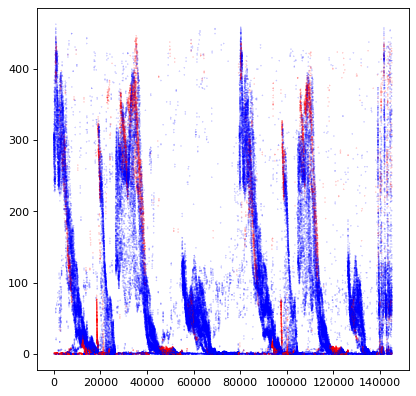

In [12]:
plt.figure(figsize=(6, 6), dpi=80)
col = ["blue"]*coordinates.shape[0]
col = np.array(col)
col[IIR>1.22] = "red"
plt.scatter(np.arange(classification_matrix.shape[0]),classification_matrix.reshape(-1,), s = 0.01, c = col)
# plt.show()
plt.savefig(log.get_directory() + os.sep + 'dot_plot')

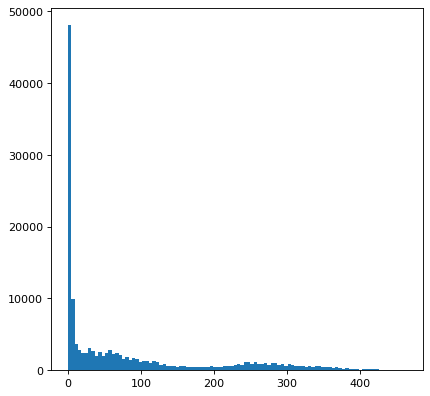

In [13]:
plt.figure(figsize=(6, 6), dpi=80)
plt.hist(classification_matrix.reshape(-1,), bins = int(B/10) )
# plt.show()
plt.savefig(log.get_directory() + os.sep + 'histogram')

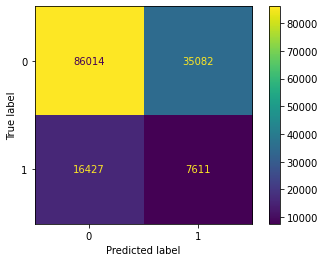

In [14]:
final_labels = np.zeros(classification_matrix.shape)
final_labels[classification_matrix>100] = 1
true_labels = np.zeros(classification_matrix.shape)
true_labels[IIR>1.22] = 1
m =confusion_matrix(true_labels, final_labels)
disp = ConfusionMatrixDisplay(m)
disp.plot()